# Starbucks Capstone Challenge


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Introduction](#0)<br>
2. [Data Understanding](#2)<br>
3. [Data Preparation and Visualization](#4)<br>
4. [Exploratory Data Analysis](#6)<br>
5. [Predictive Modeling](#8)<br>
6. [Conclusion](#10) <br>
</div>
<hr>


# Introduction<a id="0"></a>

In this study I will analyze customer behavior on the Starbucks rewards mobile app to determine which demographic groups respond best to which offer types.This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

We are given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Understanding<a id="2"></a>

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import pickle
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

# Data Prepration and Visualization<a id="4"></a>

In [15]:
portfolio.sort_values(by='offer_type').reset_index(drop=True)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
3,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
8,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
9,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


In [16]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [17]:
# looks that rows with age 118 has no gender and income and so I will drop them
profile = profile.drop(index = profile[profile.age==118].index)

In [18]:
# no duplicate rows found
profile.id.duplicated().sum()

0

In [19]:
profile.gender.unique()

array(['F', 'M', 'O'], dtype=object)

In [20]:
# number of female, male and other gender
# we will only consider female and male
profile[profile.gender=='F'].id.count(),profile[profile.gender=='M'].id.count(),profile[profile.gender=='O'].id.count()

(6129, 8484, 212)

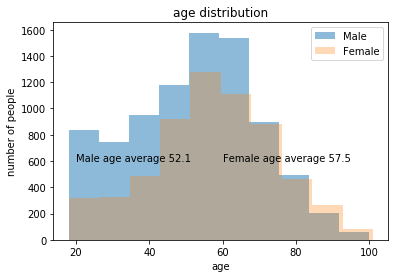

In [21]:
# plot the age distribution histogram
plt.hist(profile.age[profile.gender=='M'],alpha=0.5)
plt.hist(profile.age[profile.gender=='F'],alpha=0.3)
plt.legend(["Male","Female"])
plt.title("age distribution")
plt.xlabel("age")
plt.ylabel("number of people")
plt.annotate("Male age average {}".format(profile.age[profile.gender=='M'].mean().round(1)), (20,600),xycoords='data')
plt.annotate("Female age average {}".format(profile.age[profile.gender=='F'].mean().round(1)), (60,600),xycoords='data')

plt.show()

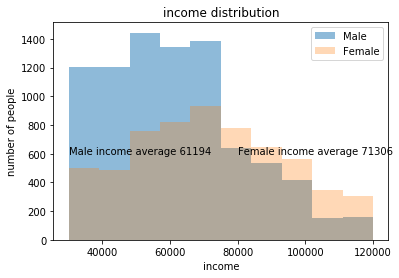

In [22]:
# plot the income distribution histogram
plt.hist(profile.income[profile.gender=='M'],alpha=0.5)
plt.hist(profile.income[profile.gender=='F'],alpha=0.3)
plt.legend(["Male","Female"])
plt.title("income distribution")
plt.xlabel("income")
plt.ylabel("number of people")
plt.annotate("Male income average {}".format(int(profile.income[profile.gender=='M'].mean())), (30000,600),xycoords='data')
plt.annotate("Female income average {}".format(int(profile.income[profile.gender=='F'].mean())), (80000,600),xycoords='data')

plt.show()

In [23]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [24]:
# combined data frame: start from transcript table and keep adding columns
comb_df = transcript

In [25]:
# extract the offer id and the amount from the value column dictionary
# and put them in two new columns: offer_id and amount

a=[list(i.values())[0] for i in comb_df.value]
b=[]
for val in a:
    if type(val)==str:
        b.append(val)
    else:
        b.append(math.nan)

c=[]
for val in a:
    if type(val)==float:
        c.append(val)
    else:
        c.append(math.nan)
        

comb_df["offer_id"] = b
comb_df["amount"] = c


In [26]:
# new columns to be filled later from profile and portfolio tables
comb_df["age"]=''
comb_df["gender"]=''
comb_df["income"]=''
comb_df["difficulty"]=''
comb_df["duration"]=''
comb_df["offer_type"]=''
comb_df["reward"]=''
comb_df.shape

(306534, 13)

In [27]:
# THIS CELL CAN BE RUN ONLY ONCE SINCE IT IS A LITTLE TIME CONSUMING

# for every person in comb_df, find the index of the corresponding person in profile table
# and then get the age, gender and income from the profile table
# if the person does not exist in profile table just fill the values with nan
a=[]
for i in comb_df.person:
    try:
        a.append(profile.index[i==profile.id].values[0])
    except:
        a.append(math.nan)
a=pd.DataFrame(a, columns=["inx"])   

indices = a[a.inx.notnull()].index.tolist()
comb_df["age"][indices] = profile.age[a.inx[indices].tolist()]
comb_df["gender"][indices] = profile.gender[a.inx[indices].tolist()]
comb_df["income"][indices] = profile.income[a.inx[indices].tolist()]

comb_df['age'] = comb_df['age'].replace([''],math.nan)
comb_df['gender'] = comb_df['gender'].replace([''],math.nan)
comb_df['income'] = comb_df['income'].replace([''],math.nan)

In [28]:
# THIS CELL CAN BE RUN ONLY ONCE SINCE IT IS A LITTLE TIME CONSUMING

# for every offer_id in comb_df, find the index of the corresponding offer_id in portfolio table
# and then get the difficulty, duration, offer_type and reward from the portfolio table


a=[]
for i in comb_df.offer_id:
    try:
        a.append(portfolio.index[i==portfolio.id].values[0])
    except:
        a.append(math.nan)
a=pd.DataFrame(a, columns=["inx"])   

indices = a[a.inx.notnull()].index.tolist()
comb_df["difficulty"][indices] = portfolio.difficulty[a.inx[indices].tolist()]
comb_df["duration"][indices] = portfolio.duration[a.inx[indices].tolist()]
comb_df["offer_type"][indices] = portfolio.offer_type[a.inx[indices].tolist()]
comb_df["reward"][indices] = portfolio.reward[a.inx[indices].tolist()]

comb_df['difficulty'] = comb_df['difficulty'].replace([''],math.nan)
comb_df['duration'] = comb_df['duration'].replace([''],math.nan)
comb_df['offer_type'] = comb_df['offer_type'].replace([''],math.nan)
comb_df['reward'] = comb_df['reward'].replace([''],math.nan)

In [29]:
# we don't need the value column anymore: all the information extracted to other columns
comb_df = comb_df.drop(columns=["value"])

In [30]:
# drop the rows that the person does not exist in the profile table
index = comb_df[comb_df.age.isnull()].index
comb_df = comb_df.drop(index=index)

In [31]:
# find duplicated rows
comb_df.duplicated().sum(), comb_df.shape

(374, (272762, 12))

In [32]:
# drop duplicated rows
comb_df = comb_df.drop_duplicates()

In [33]:
# THIS CELL CAN BE RUN ONLY ONCE SINCE IT IS A LITTLE TIME CONSUMING

# adding a new column offer_comp_and_viewed: it is 1 if the completed offer is also viewed, otherwise zero
offr_comp_df = comb_df[comb_df.event=="offer completed"]
offr_view_df = comb_df[comb_df.event=="offer viewed"]

# for each completed offer, if there exists a viewed offer with the same person and offer_id, 
# that also happened within the allowed duration time window, then that completed offer is viewed also.
a=[]
b=[]
for i,j,k,l in zip(offr_comp_df.person,offr_comp_df.offer_id,offr_comp_df.time,offr_comp_df.index):
    try:
        index_view = offr_view_df.index[(i==offr_view_df.person)&(j==offr_view_df.offer_id)].values[0]
        if ((k - offr_view_df.time[index_view]) <= (offr_view_df.duration[index_view]*24)):
            a.append(l)
            b.append(index_view)
    except:
        pass

comb_df["offer_comp_and_viewed"] =0
comb_df["offer_comp_and_viewed"].loc[a] = 1

In [34]:
comb_df.age.describe()

count    272388.000000
mean         53.838565
std          17.551277
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

In [35]:
# adding a new column age_range
comb_df["age_range"] =0
comb_df["age_range"][comb_df.age<=35] = 'young'
comb_df["age_range"][(comb_df.age>35) & (comb_df.age<=60)] = 'middle-aged'
comb_df["age_range"][comb_df.age>60] = 'old'


In [36]:
pd.DataFrame(data=(["young: less than 35","middle-aged: between 35 and 60","old: over 65"]),columns=["age-range"])

,age-range
0,young: less than 35
1,middle-aged: between 35 and 60
2,old: over 65


In [37]:
comb_df.income.describe()

count    272388.000000
mean      64328.153223
std       21241.306119
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

In [38]:
# adding a new column income_range
comb_df["income_range"] = 0
comb_df["income_range"][comb_df.income<=50000] = 'low income'
comb_df["income_range"][(comb_df.income>50000) & (comb_df.age<=80000)] = 'middle income'
comb_df["income_range"][comb_df.income>80000] = 'high income'

In [39]:
pd.DataFrame(data=(["low income: less than 50k","middle income: between 50k and 80k","high income: over 80k"]),columns=["income-range"])

,income-range
0,low income: less than 50k
1,middle income: between 50k and 80k
2,high income: over 80k


In [40]:
# save the final comb_df so next time we should not do the whole process again
comb_df.to_pickle('comb_df.pkl')

In [41]:
# retrieve the data frame
comb_df = pd.read_pickle('comb_df.pkl')

In [9]:
# final comb_df
comb_df.head()

,event,person,time,offer_id,amount,age,gender,income,difficulty,duration,offer_type,reward,offer_comp_and_viewed,age_range,income_range
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,5.0,7.0,bogo,5.0,0,old,high income
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,10.0,7.0,discount,2.0,0,old,middle income
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,M,53000.0,5.0,5.0,bogo,5.0,0,middle-aged,middle income
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,58.0,M,51000.0,0.0,4.0,informational,0.0,0,middle-aged,middle income
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,61.0,F,57000.0,20.0,10.0,discount,5.0,0,middle-aged,middle income


# Exploratory Data Analysis<a id="6"></a>

In [3]:
# average income and spend
comb_df.groupby('gender')['amount'].mean(),comb_df.groupby('gender')['income'].mean()

(gender
 F    17.490077
 M    11.606600
 O    14.798731
 Name: amount, dtype: float64, gender
 F    69537.019656
 M    60580.841635
 O    62904.161412
 Name: income, dtype: float64)

In [4]:
pd.DataFrame(data=([[11.6,'60k'],[17.5,'69k']]),columns=['average money spent','average income'],index=['male','female'])

,average money spent,average income
male,11.6,60k
female,17.5,69k


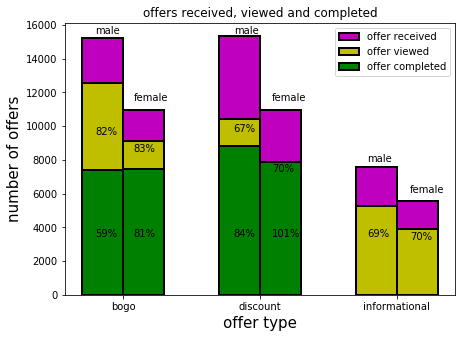

In [5]:
# plot total offers received, viewed and completed for male and female and show the ratios

a = comb_df[comb_df.gender=='M'].groupby(['event','offer_type'])['person'].count()
labels = ["bogo","discount","informational"]

# for male
offr_rec = a.loc['offer received'].values
offr_view = a.loc['offer viewed'].values
offr_comp = list(a.loc['offer completed'].values)
offr_comp.append(0)
plt.figure(figsize=(7,5))
plt.bar(labels, offr_rec,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=-0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.xlabel('offer type',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('offers received, viewed and completed')
plt.legend(['offer received','offer viewed','offer completed'])

PctView = (offr_view/offr_rec*100).astype(int)
PctComp = (offr_comp/offr_view*100).astype(int)
plt.annotate("{}%".format(PctView[0]), (.2,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.2,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.49,.61),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.49,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.77,.3),xycoords='figure fraction')

plt.annotate('male', (.2,.9),xycoords='figure fraction')
plt.annotate('male', (.49,.9),xycoords='figure fraction')
plt.annotate('male', (.77,.52),xycoords='figure fraction')


# for female
b = comb_df[comb_df.gender=='F'].groupby(['event','offer_type'])['person'].count()

offr_rec = b.loc['offer received'].values
offr_view = b.loc['offer viewed'].values
offr_comp = list(b.loc['offer completed'].values)
offr_comp.append(0)
plt.bar(labels, offr_rec,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view/offr_rec*100).astype(int)
PctComp = (offr_comp/offr_view*100).astype(int)
plt.annotate("{}%".format(PctView[0]), (.28,.55),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.28,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.57,.49),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.57,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.86,.29),xycoords='figure fraction')

plt.annotate('female', (.28,.7),xycoords='figure fraction')
plt.annotate('female', (.57,.7),xycoords='figure fraction')
plt.annotate('female', (.86,.43),xycoords='figure fraction')

plt.show()

In [6]:
# offers completed but not viewed
offers_viewed_completed = comb_df[(comb_df.event=="offer completed") & (comb_df.offer_comp_and_viewed==0)].event.count()
offers_completed = comb_df[(comb_df.event=="offer completed")].event.count()
print("ratio of completed offers that not been viewed: {}".format(offers_viewed_completed/offers_completed))

ratio of completed offers that not been viewed: 0.2549423136888057


In [4]:
# find the index for completed offers that are not viewed
index = comb_df[(comb_df.event=="offer completed") & (comb_df.offer_comp_and_viewed==0)].index

# comb_df_comp is similar to comb_df but the offers that are completed and not viewed are dropped
# we will use this data frame mainly for the rest of the study 
comb_df_comp = comb_df.drop(index = index)

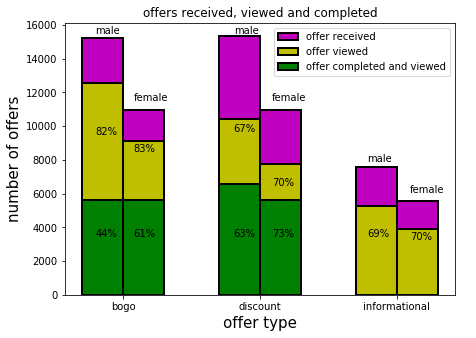

In [8]:
# plot offers received, viewed and completed (and viewed) for male and female and show the ratios
a = comb_df_comp[comb_df_comp.gender=='M'].groupby(['event','offer_type'])['person'].count()
labels = ["bogo","discount","informational"]

# for male
offr_rec = a.loc['offer received'].values
offr_view = a.loc['offer viewed'].values
offr_comp = list(a.loc['offer completed'].values)
offr_comp.append(0)
plt.figure(figsize=(7,5))
plt.bar(labels, offr_rec,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=-0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.xlabel('offer type',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('offers received, viewed and completed')
plt.legend(['offer received','offer viewed','offer completed and viewed'])

PctView = (offr_view/offr_rec*100).astype(int)
PctComp = (offr_comp/offr_view*100).astype(int)
plt.annotate("{}%".format(PctView[0]), (.2,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.2,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.49,.61),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.49,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.77,.3),xycoords='figure fraction')

plt.annotate('male', (.2,.9),xycoords='figure fraction')
plt.annotate('male', (.49,.9),xycoords='figure fraction')
plt.annotate('male', (.77,.52),xycoords='figure fraction')

# for female
b = comb_df_comp[comb_df_comp.gender=='F'].groupby(['event','offer_type'])['person'].count()

offr_rec = b.loc['offer received'].values
offr_view = b.loc['offer viewed'].values
offr_comp = list(b.loc['offer completed'].values)
offr_comp.append(0)
plt.bar(labels, offr_rec,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view/offr_rec*100).astype(int)
PctComp = (offr_comp/offr_view*100).astype(int)
plt.annotate("{}%".format(PctView[0]), (.28,.55),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.28,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.57,.45),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.57,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.86,.29),xycoords='figure fraction')

plt.annotate('female', (.28,.7),xycoords='figure fraction')
plt.annotate('female', (.57,.7),xycoords='figure fraction')
plt.annotate('female', (.86,.43),xycoords='figure fraction')

plt.show()

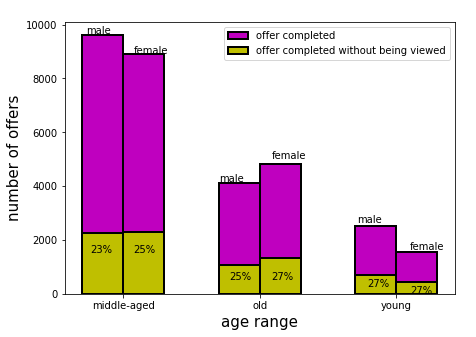

In [9]:
# offers completed and not viewed for different age groups for both male and female

# for male
a = comb_df[(comb_df.gender=='M')&(comb_df.event=="offer completed")].groupby(['age_range'])['person'].count()
b = comb_df[(comb_df.gender=='M')&(comb_df.event=="offer completed")&(comb_df.offer_comp_and_viewed==0)].groupby(['age_range'])['person'].count()

labels = ["middle-aged","old","young"]

plt.figure(figsize=(7,5))
plt.bar(labels, a,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, b,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])

ratio = (b*100/a).astype(int)
plt.annotate("{}%".format(ratio[0]), (.19,.25),xycoords='figure fraction')
plt.annotate("{}%".format(ratio[1]), (.48,.17),xycoords='figure fraction')
plt.annotate("{}%".format(ratio[2]), (.77,.15),xycoords='figure fraction')
plt.annotate('male', (.18,.9),xycoords='figure fraction')
plt.annotate('male', (.46,.46),xycoords='figure fraction')
plt.annotate('male', (.75,.34),xycoords='figure fraction')


# for female
a = comb_df[(comb_df.gender=='F')&(comb_df.event=="offer completed")].groupby(['age_range'])['person'].count()
b = comb_df[(comb_df.gender=='F')&(comb_df.event=="offer completed")&(comb_df.offer_comp_and_viewed==0)].groupby(['age_range'])['person'].count()
plt.bar(labels, a,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, b,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])

plt.xlabel('age range',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('')
plt.legend(['offer completed','offer completed without being viewed'])

ratio = (b*100/a).astype(int)
plt.annotate("{}%".format(ratio[0]), (.28,.25),xycoords='figure fraction')
plt.annotate("{}%".format(ratio[1]), (.57,.17),xycoords='figure fraction')
plt.annotate("{}%".format(ratio[2]), (.86,.13),xycoords='figure fraction')
plt.annotate('female', (.28,.84),xycoords='figure fraction')
plt.annotate('female', (.57,.53),xycoords='figure fraction')
plt.annotate('female', (.86,.26),xycoords='figure fraction')

plt.show()


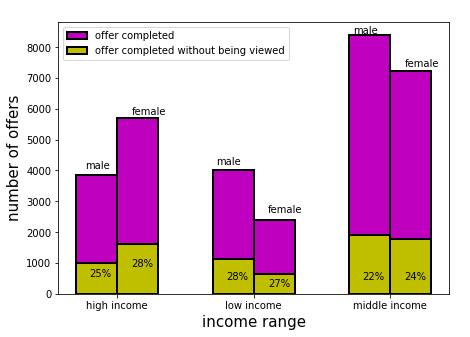

In [10]:
# offers completed and not viewed for different income groups for both male and female

# for male
a = comb_df[(comb_df.gender=='M')&(comb_df.event=="offer completed")].groupby(['income_range'])['person'].count()
b = comb_df[(comb_df.gender=='M')&(comb_df.event=="offer completed")&(comb_df.offer_comp_and_viewed==0)].groupby(['income_range'])['person'].count()

labels = ["high income","low income","middle income"]

plt.figure(figsize=(7,5))
plt.bar(labels, a,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, b,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])

ratio = (b*100/a).astype(int)
plt.annotate("{}%".format(ratio[0]), (.19,.18),xycoords='figure fraction')
plt.annotate("{}%".format(ratio[1]), (.48,.17),xycoords='figure fraction')
plt.annotate("{}%".format(ratio[2]), (.77,.17),xycoords='figure fraction')
plt.annotate('male', (.18,.5),xycoords='figure fraction')
plt.annotate('male', (.46,.51),xycoords='figure fraction')
plt.annotate('male', (.75,.9),xycoords='figure fraction')

# for female
a = comb_df[(comb_df.gender=='F')&(comb_df.event=="offer completed")].groupby(['income_range'])['person'].count()
b = comb_df[(comb_df.gender=='F')&(comb_df.event=="offer completed")&(comb_df.offer_comp_and_viewed==0)].groupby(['income_range'])['person'].count()

plt.bar(labels, a,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, b,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])

plt.xlabel('income range',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('')
plt.legend(['offer completed','offer completed without being viewed'])

ratio = (b*100/a).astype(int)
plt.annotate("{}%".format(ratio[0]), (.28,.21),xycoords='figure fraction')
plt.annotate("{}%".format(ratio[1]), (.57,.15),xycoords='figure fraction')
plt.annotate("{}%".format(ratio[2]), (.86,.17),xycoords='figure fraction')
plt.annotate('female', (.28,.66),xycoords='figure fraction')
plt.annotate('female', (.57,.37),xycoords='figure fraction')
plt.annotate('female', (.86,.8),xycoords='figure fraction')

plt.show()


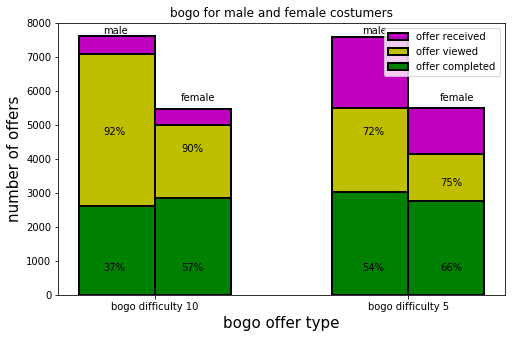

In [11]:
# bogo offer type for male and female customers

# for male
a = comb_df_comp[(comb_df_comp.offer_type=="bogo") & (comb_df_comp.gender=="M")].groupby(['event','difficulty']).count()['person']

labels = ["bogo difficulty 5","bogo difficulty 10"]

offr_rec = a.loc['offer received'].values
offr_view = a.loc['offer viewed'].values
offr_comp = a.loc['offer completed'].values
plt.figure(figsize=(8,5))
plt.bar(labels, offr_rec,align='edge',width=-0.3,color='m',edgecolor=['k','k'],linewidth=[2,2])
plt.bar(labels, offr_view,align='edge',width=-0.3,color='y',edgecolor=['k','k'],linewidth=[2,2])
plt.bar(labels, offr_comp,align='edge',width=-0.3,color='g',edgecolor=['k','k'],linewidth=[2,2])
plt.xlabel('bogo offer type',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('bogo for male and female costumers')
plt.legend(['offer received','offer viewed','offer completed'])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.7,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.7,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.2,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.2,.2),xycoords='figure fraction')
plt.annotate('male', (.7,.9),xycoords='figure fraction')
plt.annotate('male', (.2,.9),xycoords='figure fraction')

# for female
b = comb_df_comp[(comb_df_comp.offer_type=="bogo") & (comb_df_comp.gender=="F")].groupby(['event','difficulty']).count()['person']

offr_rec = b.loc['offer received'].values
offr_view = b.loc['offer viewed'].values
offr_comp = b.loc['offer completed'].values

plt.bar(labels, offr_rec,align='edge',width=0.3,color='m',edgecolor=['k','k'],linewidth=[2,2])
plt.bar(labels, offr_view,align='edge',width=0.3,color='y',edgecolor=['k','k'],linewidth=[2,2])
plt.bar(labels, offr_comp,align='edge',width=0.3,color='g',edgecolor=['k','k'],linewidth=[2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.85,.45),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.85,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.35,.55),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.35,.2),xycoords='figure fraction')
plt.annotate('female', (.85,.7),xycoords='figure fraction')
plt.annotate('female', (.35,.7),xycoords='figure fraction')


plt.show()



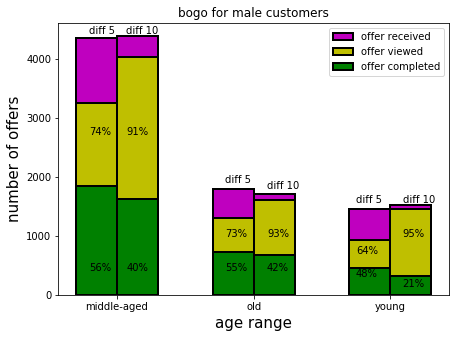

In [12]:
# bogo for male customers with different age-range
a = comb_df_comp[(comb_df_comp.offer_type=="bogo")&(comb_df_comp.gender=="M")].groupby(['event','difficulty','age_range']).count()['person']

labels = ["middle-aged","old","young"]

offr_rec = a.loc['offer received',5].values
offr_view = a.loc['offer viewed',5].values
offr_comp = a.loc['offer completed',5].values
plt.figure(figsize=(7,5))
plt.bar(labels, offr_rec,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=-0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.19,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.19,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.48,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.48,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.76,.25),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.76,.18),xycoords='figure fraction')
plt.annotate('diff 5', (.19,.9),xycoords='figure fraction')
plt.annotate('diff 5', (.48,.46),xycoords='figure fraction')
plt.annotate('diff 5', (.76,.4),xycoords='figure fraction')

offr_rec = a.loc['offer received',10].values
offr_view = a.loc['offer viewed',10].values
offr_comp = a.loc['offer completed',10].values
plt.bar(labels, offr_rec,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.27,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.27,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.57,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.57,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.86,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.86,.15),xycoords='figure fraction')
plt.annotate('diff 10', (.27,.9),xycoords='figure fraction')
plt.annotate('diff 10', (.57,.44),xycoords='figure fraction')
plt.annotate('diff 10', (.86,.4),xycoords='figure fraction')


plt.xlabel('age range',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('bogo for male customers')
plt.legend(['offer received','offer viewed','offer completed'])
plt.show()


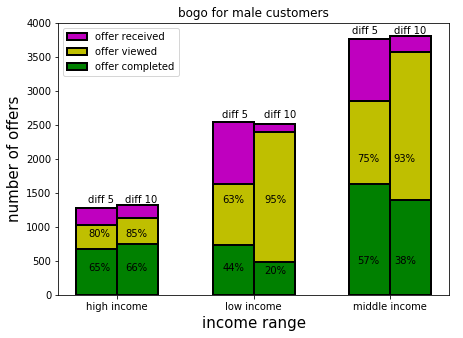

In [13]:
# bogo for male customers with different income-range

a = comb_df_comp[(comb_df_comp.offer_type=="bogo")&(comb_df_comp.gender=="M")].groupby(['event','difficulty','income_range']).count()['person']

labels = ["high income","low income","middle income"]

offr_rec = a.loc['offer received',5].values
offr_view = a.loc['offer viewed',5].values
offr_comp = a.loc['offer completed',5].values
plt.figure(figsize=(7,5))
plt.bar(labels, offr_rec,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=-0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.19,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.19,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.48,.4),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.48,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.77,.52),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.77,.22),xycoords='figure fraction')
plt.annotate('diff 5', (.19,.4),xycoords='figure fraction')
plt.annotate('diff 5', (.48,.65),xycoords='figure fraction')
plt.annotate('diff 5', (.76,.9),xycoords='figure fraction')

offr_rec = a.loc['offer received',10].values
offr_view = a.loc['offer viewed',10].values
offr_comp = a.loc['offer completed',10].values
plt.bar(labels, offr_rec,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.27,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.27,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.57,.4),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.57,.19),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.85,.52),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.85,.22),xycoords='figure fraction')
plt.annotate('diff 10', (.27,.4),xycoords='figure fraction')
plt.annotate('diff 10', (.57,.65),xycoords='figure fraction')
plt.annotate('diff 10', (.85,.9),xycoords='figure fraction')

plt.xlabel('income range',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('bogo for male customers')
plt.legend(['offer received','offer viewed','offer completed'])
plt.show()


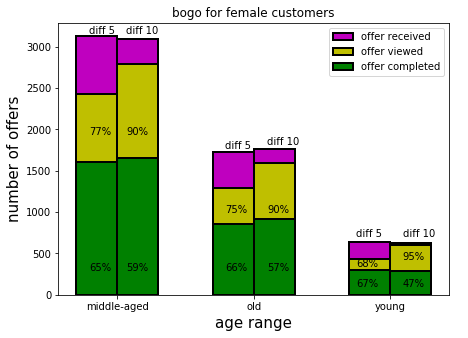

In [14]:
# bogo for female customers with different age-range
a = comb_df_comp[(comb_df_comp.offer_type=="bogo")&(comb_df_comp.gender=="F")].groupby(['event','difficulty','age_range']).count()['person']

labels = ["middle-aged","old","young"]

offr_rec = a.loc['offer received',5].values
offr_view = a.loc['offer viewed',5].values
offr_comp = a.loc['offer completed',5].values
plt.figure(figsize=(7,5))
plt.bar(labels, offr_rec,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=-0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.19,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.19,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.48,.37),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.48,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.76,.21),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.76,.15),xycoords='figure fraction')
plt.annotate('diff 5', (.19,.9),xycoords='figure fraction')
plt.annotate('diff 5', (.48,.56),xycoords='figure fraction')
plt.annotate('diff 5', (.76,.3),xycoords='figure fraction')

offr_rec = a.loc['offer received',10].values
offr_view = a.loc['offer viewed',10].values
offr_comp = a.loc['offer completed',10].values
plt.bar(labels, offr_rec,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.27,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.27,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.57,.37),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.57,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.86,.23),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.86,.15),xycoords='figure fraction')
plt.annotate('diff 10', (.27,.9),xycoords='figure fraction')
plt.annotate('diff 10', (.57,.57),xycoords='figure fraction')
plt.annotate('diff 10', (.86,.3),xycoords='figure fraction')


plt.xlabel('age range',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('bogo for female customers')
plt.legend(['offer received','offer viewed','offer completed'])
plt.show()


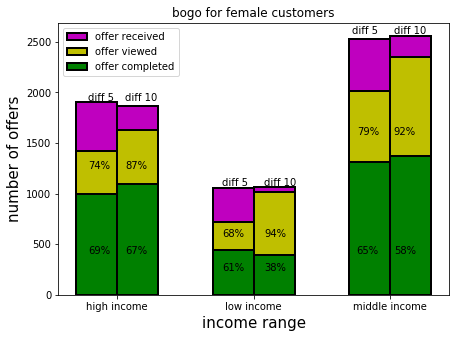

In [15]:
# bogo for female customers with different income-range

a = comb_df_comp[(comb_df_comp.offer_type=="bogo")&(comb_df_comp.gender=="F")].groupby(['event','difficulty','income_range']).count()['person']

labels = ["high income","low income","middle income"]

offr_rec = a.loc['offer received',5].values
offr_view = a.loc['offer viewed',5].values
offr_comp = a.loc['offer completed',5].values
plt.figure(figsize=(7,5))
plt.bar(labels, offr_rec,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=-0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.19,.5),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.19,.25),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.48,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.48,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.77,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.77,.25),xycoords='figure fraction')
plt.annotate('diff 5', (.19,.7),xycoords='figure fraction')
plt.annotate('diff 5', (.48,.45),xycoords='figure fraction')
plt.annotate('diff 5', (.76,.9),xycoords='figure fraction')

offr_rec = a.loc['offer received',10].values
offr_view = a.loc['offer viewed',10].values
offr_comp = a.loc['offer completed',10].values
plt.bar(labels, offr_rec,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.27,.5),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.27,.25),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.57,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.57,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.85,.6),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.85,.25),xycoords='figure fraction')
plt.annotate('diff 10', (.27,.7),xycoords='figure fraction')
plt.annotate('diff 10', (.57,.45),xycoords='figure fraction')
plt.annotate('diff 10', (.85,.9),xycoords='figure fraction')

plt.xlabel('income range',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('bogo for female customers')
plt.legend(['offer received','offer viewed','offer completed'])
plt.show()

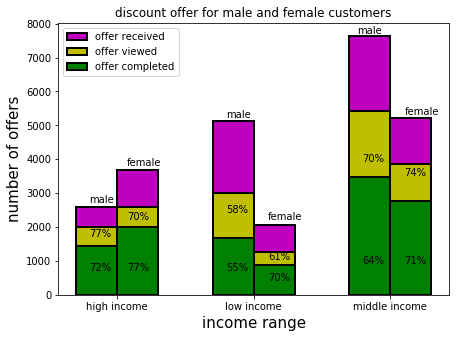

In [16]:
# discount for male and female customers with different income-range

# for male
a = comb_df_comp[(comb_df_comp.offer_type=="discount")&(comb_df_comp.gender=="M")].groupby(['event','income_range']).count()['person']

labels = ["high income","low income","middle income"]

offr_rec = a.loc['offer received'].values
offr_view = a.loc['offer viewed'].values
offr_comp = a.loc['offer completed'].values
plt.figure(figsize=(7,5))
plt.bar(labels, offr_rec,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=-0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.19,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.19,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.48,.37),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.48,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.77,.52),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.77,.22),xycoords='figure fraction')
plt.annotate('male', (.19,.4),xycoords='figure fraction')
plt.annotate('male', (.48,.65),xycoords='figure fraction')
plt.annotate('male', (.76,.9),xycoords='figure fraction')

# for female
b = comb_df_comp[(comb_df_comp.offer_type=="discount")&(comb_df_comp.gender=="F")].groupby(['event','income_range']).count()['person']

offr_rec = b.loc['offer received'].values
offr_view = b.loc['offer viewed'].values
offr_comp = b.loc['offer completed'].values
plt.bar(labels, offr_rec,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.27,.35),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.27,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.57,.23),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.57,.17),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.86,.48),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.86,.22),xycoords='figure fraction')
plt.annotate('female', (.27,.51),xycoords='figure fraction')
plt.annotate('female', (.57,.35),xycoords='figure fraction')
plt.annotate('female', (.86,.66),xycoords='figure fraction')

plt.xlabel('income range',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('discount offer for male and female customers')
plt.legend(['offer received','offer viewed','offer completed'])
plt.show()


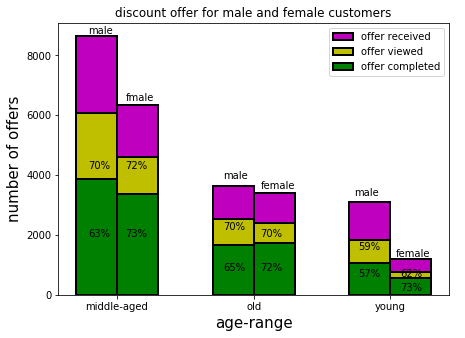

In [17]:
# discount for male and female customers with different age-range

# for male
a = comb_df_comp[(comb_df_comp.offer_type=="discount")&(comb_df_comp.gender=="M")].groupby(['event','age_range']).count()['person']

labels = ["middle-aged","old","young"]

offr_rec = a.loc['offer received'].values
offr_view = a.loc['offer viewed'].values
offr_comp = a.loc['offer completed'].values
plt.figure(figsize=(7,5))
plt.bar(labels, offr_rec,align='edge',width=-0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=-0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=-0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.19,.5),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.19,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.48,.32),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.48,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.77,.26),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.77,.18),xycoords='figure fraction')
plt.annotate('male', (.19,.9),xycoords='figure fraction')
plt.annotate('male', (.48,.47),xycoords='figure fraction')
plt.annotate('male', (.76,.42),xycoords='figure fraction')

# for female
b = comb_df_comp[(comb_df_comp.offer_type=="discount")&(comb_df_comp.gender=="F")].groupby(['event','age_range']).count()['person']

offr_rec = b.loc['offer received'].values
offr_view = b.loc['offer viewed'].values
offr_comp = b.loc['offer completed'].values
plt.bar(labels, offr_rec,align='edge',width=0.3,color='m',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_view,align='edge',width=0.3,color='y',edgecolor=['k','k','k'],linewidth=[2,2,2])
plt.bar(labels, offr_comp,align='edge',width=0.3,color='g',edgecolor=['k','k','k'],linewidth=[2,2,2])

PctView = (offr_view*100/offr_rec).astype(int)
PctComp = (offr_comp*100/offr_view).astype(int)
plt.annotate("{}%".format(PctView[0]), (.27,.5),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[0]), (.27,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[1]), (.56,.3),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[1]), (.56,.2),xycoords='figure fraction')
plt.annotate("{}%".format(PctView[2]), (.86,.18),xycoords='figure fraction')
plt.annotate("{}%".format(PctComp[2]), (.86,.14),xycoords='figure fraction')
plt.annotate('fmale', (.27,.7),xycoords='figure fraction')
plt.annotate('female', (.56,.44),xycoords='figure fraction')
plt.annotate('female', (.85,.24),xycoords='figure fraction')

plt.xlabel('age-range',fontsize=15)
plt.ylabel('number of offers',fontsize=15)
plt.title('discount offer for male and female customers')
plt.legend(['offer received','offer viewed','offer completed'])

plt.show()

# Predictive Modeling<a id="8"></a>

In [3]:
# find the index for completed offers that are not viewed
index = comb_df[(comb_df.event=="offer completed") & (comb_df.offer_comp_and_viewed==0)].index

# comb_df_comp is similar to comb_df but the offers that are completed and not viewed are dropped
comb_df_comp = comb_df.drop(index = index)

In [8]:
comb_df.head()

,event,person,time,offer_id,amount,age,gender,income,difficulty,duration,offer_type,reward,offer_comp_and_viewed,age_range,income_range
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,5.0,7.0,bogo,5.0,0,old,high income
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,10.0,7.0,discount,2.0,0,old,middle income
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,M,53000.0,5.0,5.0,bogo,5.0,0,middle-aged,middle income
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,58.0,M,51000.0,0.0,4.0,informational,0.0,0,middle-aged,middle income
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,61.0,F,57000.0,20.0,10.0,discount,5.0,0,middle-aged,middle income


In [5]:
# THIS CELL CAN BE RUN ONLY ONCE SINCE IT IS A LITTLE TIME CONSUMING

# adding a new column offer_rec_and_comp: it is 1 if the offer received is also completed 
offr_comp_df = comb_df_comp[comb_df_comp.event=="offer completed"]
offr_rec_df = comb_df_comp[comb_df_comp.event=="offer received"]

# for each received offer, if there exists a completed offer with the same person and offer_id, 
# that also happened within the allowed duration time window, then that received offer is viewed and completed also.
a=[]
b=[]
for i,j,k,l in zip(offr_rec_df.person,offr_rec_df.offer_id,offr_rec_df.time,offr_rec_df.index):
    try:
        index_comp = offr_comp_df.index[(i==offr_comp_df.person)&(j==offr_comp_df.offer_id)].values[0]
        if ((offr_comp_df.time[index_comp]-k) <= (offr_comp_df.duration[index_comp]*24)):
            a.append(l)
            b.append(index_comp)
            offr_comp_df = offr_comp_df.drop(index=index_comp)
    except:
        pass

comb_df_comp["offer_rec_and_comp"] =0
comb_df_comp["offer_rec_and_comp"].loc[a] = 1

In [11]:
# save the final comb_df_comp 
comb_df_comp.to_pickle('comb_df_comp.pkl')

In [2]:
# retrieve the data frame
comb_df_comp = pd.read_pickle('comb_df_comp.pkl')

In [3]:
comb_df_comp.head()

,event,person,time,offer_id,amount,age,gender,income,difficulty,duration,offer_type,reward,offer_comp_and_viewed,age_range,income_range,offer_rec_and_comp
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,5.0,7.0,bogo,5.0,0,old,high income,1
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,10.0,7.0,discount,2.0,0,old,middle income,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,M,53000.0,5.0,5.0,bogo,5.0,0,middle-aged,middle income,1
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,58.0,M,51000.0,0.0,4.0,informational,0.0,0,middle-aged,middle income,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,61.0,F,57000.0,20.0,10.0,discount,5.0,0,middle-aged,middle income,0


In [4]:
# only select the rows associsted with offer received and offer not informational
df = comb_df_comp[(comb_df_comp.event=="offer received")&(comb_df_comp.offer_type!="informational")]

# add the dummy columns for categorical columns
df = pd.get_dummies(df,columns=["offer_type","gender"])

X = df[["age","income","difficulty","duration","reward","offer_type_bogo","offer_type_discount","gender_F","gender_M","gender_O"]]
y = df["offer_rec_and_comp"]


In [5]:
df.shape, comb_df_comp["offer_rec_and_comp"].sum()

((53201, 19), 23894)

In [6]:
X.head()

,age,income,difficulty,duration,reward,offer_type_bogo,offer_type_discount,gender_F,gender_M,gender_O
0,75.0,100000.0,5.0,7.0,5.0,1,0,1,0,0
2,68.0,70000.0,10.0,7.0,2.0,0,1,0,1,0
5,65.0,53000.0,5.0,5.0,5.0,1,0,0,1,0
8,61.0,57000.0,20.0,10.0,5.0,0,1,1,0,0
9,62.0,71000.0,20.0,10.0,5.0,0,1,1,0,0


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import f1_score

In [16]:
# predictive modeling with default sklearn parameters
# Decision Tree
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
# store the results
DT = [clf.score(X_test,y_test),f1_score(y_test, pred),
      clf.score(X_train,y_train),f1_score(y_train, clf.predict(X_train))]


# Random Forest
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
# store the results
RF = [clf.score(X_test,y_test),f1_score(y_test, pred),
      clf.score(X_train,y_train),f1_score(y_train, clf.predict(X_train))]                                         
                                          
# Logistic Regression
clf = LogisticRegression()
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
# store the results
LR = [clf.score(X_test,y_test),f1_score(y_test, pred),
      clf.score(X_train,y_train),f1_score(y_train, clf.predict(X_train))] 

# SVC
clf = SVC()
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
# store the results
SV = [clf.score(X_test,y_test),f1_score(y_test, pred),
      clf.score(X_train,y_train),f1_score(y_train, clf.predict(X_train))] 


# summarize all the 4 models results
results = pd.DataFrame(columns=["Decision Tree","Random Forest","Logistic","SVC"],
                       index=["accuracy on test data","F1 test data","accuracy on train data","F1 train data"])

results["Decision Tree"] = DT
results["Random Forest"] = RF
results["Logistic"] = LR
results["SVC"] = SV

results

,Decision Tree,Random Forest,Logistic,SVC
accuracy on test data,0.576074,0.587351,0.585659,0.601353
F1 test data,0.489417,0.527087,0.490583,0.524759
accuracy on train data,0.874483,0.860009,0.593985,0.755992
F1 train data,0.845204,0.841686,0.501500,0.711600


In [17]:
from sklearn.model_selection import GridSearchCV

# Decision Tree
parameters = {'max_depth':[5,10,20], 'max_features':[5,6,7,8,9,10]}
clf = GridSearchCV(DecisionTreeClassifier(), parameters)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
# store the results
DT = [clf.score(X_test,y_test),f1_score(y_test, pred),
      clf.score(X_train,y_train),f1_score(y_train, clf.predict(X_train)),clf.best_params_]


# Random Forest
parameters = {'max_depth':[5,10,20], 'max_features':[5,8,10],'n_estimators':[25,100]}
clf = GridSearchCV(RandomForestClassifier(), parameters)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
# store the results
RF = [clf.score(X_test,y_test),f1_score(y_test, pred),
      clf.score(X_train,y_train),f1_score(y_train, clf.predict(X_train)),clf.best_params_]                                         
                                          
# Logistic Regression
parameters = {'max_iter':[100,200], 'C':[1,0.1,0.01],'penalty':('l1','l2')}
clf = GridSearchCV(LogisticRegression(solver='liblinear'), parameters)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
# store the results
LR = [clf.score(X_test,y_test),f1_score(y_test, pred),
      clf.score(X_train,y_train),f1_score(y_train, clf.predict(X_train)),clf.best_params_] 

# SVC
parameters = {'C':[1,0.1]}
clf = GridSearchCV(SVC(), parameters)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
# store the results
SV = [clf.score(X_test,y_test),f1_score(y_test, pred),
      clf.score(X_train,y_train),f1_score(y_train, clf.predict(X_train)),clf.best_params_] 


# summarize all the 4 models results
results = pd.DataFrame(columns=["Decision Tree","Random Forest","Logistic","SVC"],
                       index=["accuracy on test data","F1 test data","accuracy on train data","F1 train data","best params"])

results["Decision Tree"] = DT
results["Random Forest"] = RF
results["Logistic"] = LR
results["SVC"] = SV


In [19]:
pd.set_option('display.max_colwidth', -1)
results

,Decision Tree,Random Forest,Logistic,SVC
accuracy on test data,0.637346,0.645334,0.625411,0.601353
F1 test data,0.59823,0.608181,0.539829,0.524759
accuracy on train data,0.663581,0.672039,0.618468,0.755992
F1 train data,0.625164,0.634722,0.529878,0.7116
best params,"{'max_depth': 10, 'max_features': 8}","{'max_depth': 10, 'max_features': 8, 'n_estimators': 100}","{'C': 1, 'max_iter': 100, 'penalty': 'l1'}",{'C': 1}


# Conclusion<a id="10"></a>

In this study we analyzed customer behavior on the Starbucks rewards mobile app to determine which demographic groups respond best to which offer types:<br>
Women are in general more willing to spend more and also complete an offer.<br>
Discount offer is more popular compared to bogo offer, with bogo10 being the least desired offer to complete.<br> 
Male, young and low-income customers have lowest completion rates. This may not be just because of money, for example for bogo sometimes you need to be more than one person to be able to complete the offer, however this may not be the case specifically for a young person.<br> 
High-income people has the highest offer completion rate. Old and middle-aged groups have very similar pattern in viewing and completing an offer.<br>
On the other hand, based on the predictive modeling and using four classification model, we were able to predict if a received offer would be completed with 64% accuracy and F-score of 61% with Random Forest Classification.
